In [1]:
import torch

import torchvision

import torch.nn as nn

import torch.nn.functional as F

import torchvision.transforms as T

from torchvision.transforms import Resize

from torchvision import datasets, transforms

import torch.optim as optim

from torch.utils.data import DataLoader


from tqdm import tqdm

import numpy as np

from PIL import Image


In [2]:
from torchvision.datasets import CIFAR10
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.optim.lr_scheduler import CosineAnnealingLR
import wandb
import time
from torchsummary import summary

## Self-Attention

In [3]:
class SelfAttention(nn.Module):

    def __init__(self, embedding_dim=768, key_dim=64):

        super(SelfAttention, self).__init__()

        self.embedding_dim = embedding_dim   # D -> embedding dimensionaltiy
        self.key_dim = key_dim               # D_h -> key, query, value dimensionality

        # U_kqv weight matrix

        self.W = nn.Parameter(torch.randn(embedding_dim, 3*key_dim))

    def forward(self, x):

        key_dim = self.key_dim

        # get query, key and value projection

        qkv = torch.matmul(x, self.W)

        # get query, key, value

        q = qkv[:, :, :key_dim]

        k = qkv[:, :, key_dim:key_dim*2 ]

        v = qkv[:, :, key_dim*2:]


        # compute dot product of the all query with all keys

        k_T = torch.transpose(k, -2, -1)   # get transpose of key

        dot_products = torch.matmul(q, k_T)

        # divide each by √Dh

        scaled_dot_products = dot_products / np.sqrt(key_dim)

        # apply a softmax function to obtain attention weights -> A

        attention_weights = F.softmax(scaled_dot_products, dim=1)

        # get weighted values

        weighted_values = torch.matmul(attention_weights, v)

        # return weighted_values

        return weighted_values

## Multi-Head Self-Attention


In [4]:
class MultiHeadSelfAttention(nn.Module):

    def __init__(self, embedding_dim=768, num_heads=12):

        super(MultiHeadSelfAttention, self).__init__()

        self.num_heads = num_heads            # set number of heads (k)

        self.embedding_dim = embedding_dim    # set dimensionality


        assert embedding_dim % num_heads == 0   # dimensionality should be divisible by number of heads

        self.key_dim = embedding_dim // n_head   # set key,query and value dimensionality

        # init self-attentions

        self.attention_list = [SelfAttention(embedding_dim, self.key_dim) for _ in range(num_heads)]

        self.multi_head_attention = nn.ModuleList(self.attention_list)

        # init U_msa weight matrix

        self.W = nn.Parameter(torch.randn(num_heads * self.key_dim, embedding_dim))


    def forward(self, x):

        # compute self-attention scores of each head

        attention_scores = [attention(x) for attention in self.multi_head_attention]


        # concat attentions

        Z = torch.cat(attention_scores, -1)

        # compute multi-head attention score

        attention_score = torch.matmul(Z, self.W)

        return attention_score



## Multi-Layer Perceptron


In [5]:
class MultiLayerPerceptron(nn.Module):

    def __init__(self, embedding_dim=768, hidden_dim=3072):

        super(MultiLayerPerceptron, self).__init__()

        self.mlp = nn.Sequential(

                            nn.Linear(embedding_dim, hidden_dim),

                            nn.GELU(),

                            nn.Linear(hidden_dim, embedding_dim)

                   )

    def forward(self, x):

        # pass through multi-layer perceptron

        x = self.mlp(x)

        return x

## Transformer Encoder


In [6]:
class TransformerEncoder(nn.Module):

    def __init__(self, embedding_dim=768, num_heads=12, hidden_dim=3072, dropout_prob=0.1):

        super(TransformerEncoder, self).__init__()


        self.MSA = MultiHeadSelfAttention(embedding_dim, num_heads)

        self.MLP = MultiLayerPerceptron(embedding_dim, hidden_dim)

        self.layer_norm1 = nn.LayerNorm(embedding_dim)

        self.layer_norm2 = nn.LayerNorm(embedding_dim)


        self.dropout1 = nn.Dropout(p=dropout_prob)

        self.dropout2 = nn.Dropout(p=dropout_prob)

        self.dropout3 = nn.Dropout(p=dropout_prob)


    def forward(self, x):

        # apply dropout

        out_1 = self.dropout1(x)

        # apply layer normalization
        out_2 = self.layer_norm1(out_1)

        # compute multi-head self-attention

        msa_out = self.MSA(out_2)

        # apply dropout

        out_3 = self.dropout2(msa_out)

        # apply residual connection

        res_out = x + out_3

        # apply layer normalization

        out_4 = self.layer_norm2(res_out)

        # compute mlp output

        mlp_out = self.MLP(out_4)

        # apply dropout

        out_5 = self.dropout3(mlp_out)

        # apply residual connection

        output = res_out + out_5

        return output

## Transformer Encoder


In [7]:
class TransformerEncoder(nn.Module):

    def __init__(self, embedding_dim=768, num_heads=12, hidden_dim=3072, dropout_prob=0.1):

        super(TransformerEncoder, self).__init__()


        self.MSA = MultiHeadSelfAttention(embedding_dim, num_heads)

        self.MLP = MultiLayerPerceptron(embedding_dim, hidden_dim)

        self.layer_norm1 = nn.LayerNorm(embedding_dim)

        self.layer_norm2 = nn.LayerNorm(embedding_dim)


        self.dropout1 = nn.Dropout(p=dropout_prob)

        self.dropout2 = nn.Dropout(p=dropout_prob)

        self.dropout3 = nn.Dropout(p=dropout_prob)


    def forward(self, x):

        # apply dropout

        out_1 = self.dropout1(x)

        # apply layer normalization
        out_2 = self.layer_norm1(out_1)

        # compute multi-head self-attention

        msa_out = self.MSA(out_2)

        # apply dropout

        out_3 = self.dropout2(msa_out)

        # apply residual connection

        res_out = x + out_3

        # apply layer normalization

        out_4 = self.layer_norm2(res_out)

        # compute mlp output

        mlp_out = self.MLP(out_4)

        # apply dropout

        out_5 = self.dropout3(mlp_out)

        # apply residual connection

        output = res_out + out_5

        return output

## MLP Classification Head


In [8]:
class MLPHead(nn.Module):

    def __init__(self, embedding_dim=768, num_classes=10, fine_tune=False):

        super(MLPHead, self).__init__()

        self.num_classes = num_classes



        if not fine_tune:

            # hidden layer with tanh activation function

            self.mlp_head = nn.Sequential(

                                    nn.Linear(embedding_dim, 3072),  # hidden layer

                                    nn.Tanh(),

                                    nn.Linear(3072, num_classes)    # output layer

                            )
        else:

            # single linear layer

            self.mlp_head = nn.Linear(embedding_dim, num_classes)



    def forward(self, x):

        x = self.mlp_head(x)

        return x



## Vision Transformer


In [9]:
class VisionTransformer(nn.Module):

    def __init__(self, patch_size=16, image_size=224, channel_size=3,

                     num_layers=12, embedding_dim=768, num_heads=12, hidden_dim=3072,

                            dropout_prob=0.1, num_classes=10, pretrain=True):

        super(VisionTransformer, self).__init__()



        self.patch_size = patch_size

        self.channel_size = channel_size

        self.num_layers = num_layers

        self.embedding_dim = embedding_dim

        self.num_heads = num_heads

        self.hidden_dim = hidden_dim

        self.dropout_prob = dropout_prob

        self.num_classes = num_classes



        # get number of patches of the image

        self.num_patches = int(image_size ** 2 / patch_size ** 2)   # height * width / patch size ^ 2



        # trainable linear projection for mapping dimnesion of patches (weight matrix E)

        self.W = nn.Parameter(

                    torch.randn( patch_size * patch_size * channel_size, embedding_dim))



        # position embeddings (E_pos)

        self.pos_embedding = nn.Parameter(torch.randn(self.num_patches + 1, embedding_dim))



        # learnable class token embedding (x_class)

        self.class_token = nn.Parameter(torch.rand(1, embedding_dim))



        # stack transformer encoder layers

        transformer_encoder_list = [

            TransformerEncoder(embedding_dim, num_heads, hidden_dim, dropout_prob)

                    for _ in range(num_layers)]

        self.transformer_encoder_layers = nn.Sequential(*transformer_encoder_list)



        # mlp head

        self.mlp_head = MLPHead(embedding_dim, num_classes)



    def forward(self, x):

        # get patch size and channel size

        P, C = self.patch_size, self.channel_size



        # split image into patches

        patches = x.unfold(1, C, C).unfold(2, P, P).unfold(3, P, P)

        patches = patches.contiguous().view(patches.size(0), -1, C * P * P).float()



        # linearly embed patches

        patch_embeddings = torch.matmul(patches , self.W)


        # add class token

        batch_size = patch_embeddings.shape[0]

        patch_embeddings = torch.cat((self.class_token.repeat(batch_size, 1, 1), patch_embeddings), 1)



        # add positional embedding

        patch_embeddings = patch_embeddings + self.pos_embedding



        # feed patch embeddings into a stack of Transformer encoders

        transformer_encoder_output = self.transformer_encoder_layers(patch_embeddings)



        # extract [class] token from encoder output

        output_class_token = transformer_encoder_output[:, 0]



        # pass token through mlp head for classification

        y = self.mlp_head(output_class_token)



        return y

In [10]:
# image_size = 224; channel_size = 3


# # number of classes CIFAR-10

# n_class = 10

# # dropout probability

# dropout_prob = 0.1


# # Vit-base model configurations

# n_layer = 12; embedding_dim = 768; n_head = 12; hidden_dim=3072


# # read and resize image

# image = Image.open('img.jpg').resize((image_size, image_size))



# # convert PIL image to tensor

# X = T.PILToTensor()(image)


# # add batch dimension

# X =  X[None, ...]    # batch size = 1


# patch_size = 16



# vision_transformer = VisionTransformer(patch_size, image_size, channel_size,

#                             n_layer, embedding_dim, n_head, hidden_dim, dropout_prob, n_class)



# # compute vision transformer output

# vit_output = vision_transformer(X)



# assert vit_output.size(dim=1) == n_class

# print(vit_output.shape)



# # get class probabilities

# probabilities = F.softmax(vit_output[0], dim=0)
# print(probabilities)


# # probabilities should sum up to 1

# print(torch.sum(probabilities))

In [11]:
# Set device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
batch_size = 32
epochs = 4
learning_rate = 0.001
weight_decay = 0.3
t_max = 80000
log_interval = 10
workers = 4
seed = 1

image_size = 224
channel_size = 3
n_class = 10
n_layer = 12
embedding_dim = 768
n_head = 12
hidden_dim=3072
patch_size = 16
dropout_prob = 0.1

# Ensure reproducibility
torch.manual_seed(seed)
if device == 'cuda':
    cudnn.deterministic = True
    cudnn.benchmark = False

# Initialize the Vision Transformer model
model = VisionTransformer(patch_size, image_size, channel_size,

                            n_layer, embedding_dim, n_head, hidden_dim, dropout_prob, n_class)

# Optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss().to(device)

# Learning rate scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=t_max, eta_min=0)

# Setup WandB for logging
wandb.init(project='vision-transformer', config={
    'batch_size': batch_size,
    'epochs': epochs,
    'learning_rate': learning_rate,
    'weight_decay': weight_decay,
    't_max': t_max,
})


Using device: cuda


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: saadsohail (saadsohail-fast-nuces). Use `wandb login --relogin` to force relogin


In [12]:
# Define transformations
transform = transforms.Compose([
    Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


# Load CIFAR-10 dataset
train_dataset = CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = CIFAR10(root='./data', train=False, transform=transform, download=True)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [13]:
# Calculate the total number of trainable parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params:,}")


Total trainable parameters: 88,152,586


In [14]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [15]:
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Initialize tqdm progress bar for the entire epoch
    epoch_pbar = tqdm(total=len(train_loader), desc=f"Epoch {epoch}/{epochs}", unit="batch", leave=True)

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        # Calculate accuracy using the provided function
        top1_acc, = accuracy(output, target, topk=(1,))
        running_loss += loss.item()

        # Update tqdm progress bar
        epoch_pbar.set_postfix(loss=loss.item(), top1_acc=top1_acc.item())
        epoch_pbar.update(1)  # Increment the progress bar by 1

    epoch_pbar.close()  # Close the progress bar when the epoch ends

    # Log training metrics to WandB
    wandb.log({'train_loss': running_loss / len(train_loader), 'train_accuracy': top1_acc.item()})
    scheduler.step()

    print(f"Epoch {epoch}, Top-1 Accuracy: {top1_acc.item()}%")


Epoch 0/4: 100%|██████████| 1563/1563 [30:28<00:00,  1.17s/batch, loss=2.68, top1_acc=12.5]


Epoch 0, Top-1 Accuracy: 12.5%


Epoch 1/4: 100%|██████████| 1563/1563 [30:43<00:00,  1.18s/batch, loss=2.48, top1_acc=18.8]


Epoch 1, Top-1 Accuracy: 18.75%


Epoch 2/4: 100%|██████████| 1563/1563 [30:56<00:00,  1.19s/batch, loss=2.63, top1_acc=18.8]


Epoch 2, Top-1 Accuracy: 18.75%


Epoch 3/4: 100%|██████████| 1563/1563 [30:54<00:00,  1.19s/batch, loss=2.41, top1_acc=18.8]

Epoch 3, Top-1 Accuracy: 18.75%


In [39]:
# Optional: Save the model at each epoch
torch.save(model.state_dict(), f"ViT_epoch_{epoch}.pt")
model=torch.load('ViT_epoch_3.pt')


<ipython-input-39-b76cc4f2897d>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model=torch.load('ViT_epoch_3.pt')


In [18]:
# Validation loop
model.eval()
correct = 0
total = 0
with torch.no_grad():
    # Use tqdm for validation as well
    val_pbar = tqdm(test_loader, desc=f"Validation after Epoch {epoch}", unit="batch", leave=True)
    for data, target in val_pbar:
        data, target = data.to(device), target.to(device)
        output = model(data)

        # Calculate top-1 accuracy for the validation set
        top1_acc, = accuracy(output, target, topk=(1,))
        correct += (top1_acc > 0)
        total += target.size(0)

        # Update tqdm description with current validation accuracy
        val_pbar.set_postfix(test_top1_acc=top1_acc.item())

    test_accuracy = 100. * correct / total
    print(f"Test Top-1 Accuracy after Epoch {epoch}: {test_accuracy}%")
    wandb.log({'test_accuracy': test_accuracy})

Validation after Epoch 3: 100%|██████████| 313/313 [02:07<00:00,  2.45batch/s, test_top1_acc=6.25]

Test Top-1 Accuracy after Epoch 3: tensor([3.1300], device='cuda:0')%


Predicted class: 4, Actual class: 3
Class probabilities: [[0.00714832 0.02824773 0.14058995 0.02055086 0.52897453 0.0145304
  0.13717222 0.0758087  0.01677315 0.03020407]]


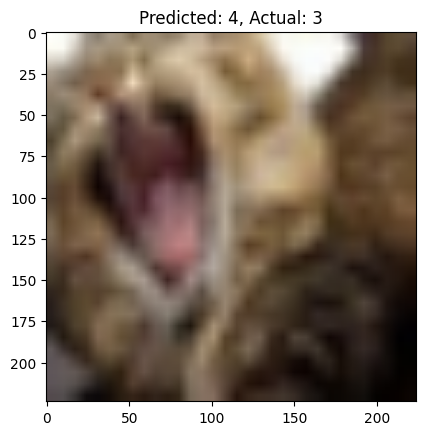

In [38]:
# Switch the model to evaluation mode
model.eval()

# Load a single sample from the CIFAR-10 test dataset
sample_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)
data_iter = iter(sample_loader)
sample_image, sample_label = next(data_iter)

# Move the sample to the appropriate device
sample_image = sample_image.to(device)
sample_label = sample_label.to(device)

# Perform inference
with torch.no_grad():
    output = model(sample_image)  # Model output (logits)
    probabilities = F.softmax(output, dim=1)  # Convert logits to probabilities
    predicted_class = probabilities.argmax(dim=1)  # Get predicted class index

# Print results
print(f"Predicted class: {predicted_class.item()}, Actual class: {sample_label.item()}")
print(f"Class probabilities: {probabilities.cpu().numpy()}")

# Visualize the sample image (Optional)
import matplotlib.pyplot as plt

# Denormalize the image for visualization
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])
sample_image_np = sample_image.cpu().numpy().squeeze().transpose((1, 2, 0))
sample_image_np = sample_image_np * std + mean  # Denormalize
sample_image_np = np.clip(sample_image_np, 0, 1)
plt.imshow(sample_image_np)
plt.title(f"Predicted: {predicted_class.item()}, Actual: {sample_label.item()}")
plt.show()
